In [54]:
import sys
sys.path.append('..')

import os
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

In [19]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [20]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [48]:
path_shp_recorridos = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\RECORRIDOS.shp'
#path_shp_plan
#path_xlsx_parte

In [49]:
# Cargar los archivos Shapefile
gdf_recorridos = gpd.read_file(path_shp_recorridos)
#gdf_plan = gpd.read_file(path_shp_plan)

In [91]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def obtener_parte_diario_sin_cod_labor():
    engine = obtener_engine()
    try:
        query = """
            SELECT DISTINCT idd, unidad_01, unidad_02
            FROM drones_pulverizacion.parte_diario_pulv 
            WHERE idd IS NOT NULL AND cod_labor IS NULL
        """
        # Usar pandas si no hay geometría involucrada
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return pd.DataFrame()

def obtener_propiedad_por_idd(idd):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_pulverizacion.parte_diario_pulv WHERE idd= {idd}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def actualizar_area_rociada(id, val):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_pulverizacion.parte_diario_pulv
                SET 
                    area_rocia= :val
                WHERE id = :id
            """)
            conn.execute(query, {"id": id, "val": val})
            print(f"✔️ Area rociada actualizada de lote id: {id}")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")

def actualizar_faltantes_por_idd(idd, fecha_intermedia, numero_semana, num_vuelos, total_flight_time, total_caudal):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_pulverizacion.parte_diario_pulv
                SET 
                    fecha= :fecha_intermedia,
                    semana= :numero_semana,
                    num_vuelos= :num_vuelos,
                    horas_vuel= :total_flight_time,
                    total_caud= :total_caudal
                WHERE idd = :idd
            """)
            conn.execute(query, {
                "idd": idd, 
                "fecha_intermedia": fecha_intermedia,
                "numero_semana": numero_semana,
                "num_vuelos": num_vuelos,
                "total_flight_time": total_flight_time,
                "total_caudal": total_caudal,
            })
            print(f"✔️ Datos faltantes de idd: {idd} cargados correctamente")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")

In [37]:
propiedades_procesar = obtener_parte_diario_sin_cod_labor()
propiedades_procesar

,idd,unidad_01,unidad_02
0,42,375,SANTA ANITA--GUILLERMO SANTIAGO


In [39]:
for i, row in propiedades_procesar.iterrows():
    print(row.idd)

42


In [40]:
idd = 42

In [50]:
selec_recorridos = gdf_recorridos[gdf_recorridos['idd']==42]

In [52]:
# selccion de lotes planificados
selec_plan = obtener_propiedad_por_idd(idd)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19152\1881393232.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


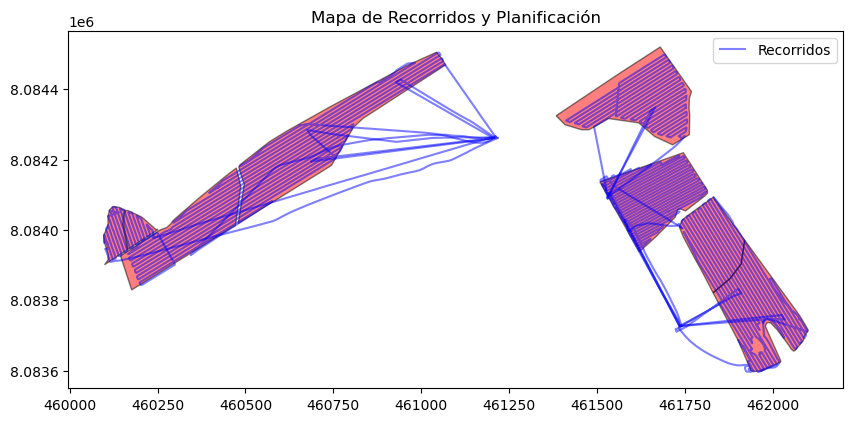

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
# Graficar las capas
selec_recorridos.plot(ax=ax, color="blue", alpha=0.5, edgecolor="black", label="Recorridos")
selec_plan.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", label="Planificación")
# Configurar la visualización
ax.set_title("Mapa de Recorridos y Planificación")
ax.legend()
# Mostrar el gráfico
plt.show()

In [58]:
selec_recorridos.loc[:, "fecha"] = pd.to_datetime(selec_recorridos["fecha"])

In [59]:
# Obtener la fecha mínima y máxima
fecha_min = selec_recorridos["fecha"].min()
fecha_max = selec_recorridos["fecha"].max()
fecha_intermedia = fecha_min + (fecha_max - fecha_min) / 2

In [61]:
numero_semana = fecha_intermedia.isocalendar().week

In [63]:
area_total_pulv = selec_recorridos['area'].sum()
area_total_pulv

27.776000138879997

In [64]:
num_vuelos = len(selec_recorridos)
num_vuelos

15

In [66]:
selec_recorridos = selec_recorridos.copy()
# Convert "fl_time" to total seconds
selec_recorridos["fl_time_sec"] = selec_recorridos["fl_time"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]))
# Sum all seconds
total_seconds = selec_recorridos["fl_time_sec"].sum()
# Convert back to hh:mm:ss format
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60
total_flight_time = f"{hours:02}:{minutes:02}:{seconds:02}"
total_flight_time

'02:06:34'

In [67]:
total_caudal = selec_recorridos['spray'].sum()
total_caudal

288.755

In [69]:
# Aplicar el buffer a la geometría
selec_recorridos["geometry"] = selec_recorridos.geometry.buffer(5.5)

In [70]:
# Disolver todas las geometrías en un solo polígono
buffer_dissolved = selec_recorridos.dissolve()

In [71]:
# Calcular la intersección
interseccion = gpd.overlay(buffer_dissolved, selec_plan, how="intersection")

In [72]:
# Calcular el área de cada polígono de la intersección
interseccion["area_rociado"] = interseccion.geometry.area / 10000

In [73]:
resumen = interseccion[['id_2', 'unidad_05', 'area_2', 'area_rociado']].copy()

In [74]:
suma_area_rociada = resumen['area_rociado'].sum()
area_rociada_real = area_total_pulv  # aquí pon tu valor real
# Factor inicial de ajuste
factor_ajuste = area_rociada_real / suma_area_rociada
# Ajuste proporcional inicial
resumen['area_ajustada'] = resumen['area_rociado'] * factor_ajuste
# Verificar que no exceda area_2 y corregir iterativamente si es necesario
while any(resumen['area_ajustada'] > resumen['area_2']):
    exceso = resumen['area_ajustada'] > resumen['area_2']
    resumen.loc[exceso, 'area_ajustada'] = resumen.loc[exceso, 'area_2']
    # Recalcular factor solo con las filas no ajustadas al máximo permitido
    area_ajustada_parcial = resumen.loc[~exceso, 'area_ajustada'].sum()
    area_restante = area_rociada_real - resumen.loc[exceso, 'area_ajustada'].sum()
    # Evitar división por cero
    if area_ajustada_parcial == 0:
        break
    nuevo_factor = area_restante / area_ajustada_parcial
    resumen.loc[~exceso, 'area_ajustada'] *= nuevo_factor

In [75]:
resumen["porcen_rociado"] = (resumen["area_ajustada"]) / (resumen["area_2"])

In [76]:
resumen["dif_area"] = resumen["area_2"] - resumen["area_ajustada"]

In [78]:
resumen

,id_2,unidad_05,area_2,area_rociado,area_ajustada,porcen_rociado,dif_area
0,245,L17.3,4.269434,4.147152,3.926490,0.919674,0.342945
1,246,L18.3,7.041418,7.022269,6.648627,0.944217,0.392791
2,247,L15.2,5.451087,4.855147,4.596813,0.843284,0.854274
3,248,L10.2,2.890233,2.890233,2.736449,0.946792,0.153784
4,249,L13,4.448583,4.446395,4.209810,0.946326,0.238773
5,252,L10.1,4.714146,4.690599,4.441021,0.942063,0.273125
6,250,L17.1.2,0.714091,0.713254,0.675303,0.945682,0.038788
7,251,L17.1.3,0.571920,0.571919,0.541489,0.946791,0.030432


In [84]:
for i, row in resumen.iterrows():
    print(row.id_2, row.area_ajustada)
    actualizar_area_rociada(row.id_2, row.area_ajustada)

245 3.9264896039700963
✔️ Area rociada actualizada de lote id: 245
246 6.648626745154702
✔️ Area rociada actualizada de lote id: 246
247 4.596812751213864
✔️ Area rociada actualizada de lote id: 247
248 2.7364487186670807
✔️ Area rociada actualizada de lote id: 248
249 4.209809679987053
✔️ Area rociada actualizada de lote id: 249
252 4.441020686850077
✔️ Area rociada actualizada de lote id: 252
250 0.6753033506892372
✔️ Area rociada actualizada de lote id: 250
251 0.5414886023478847
✔️ Area rociada actualizada de lote id: 251


In [92]:
actualizar_faltantes_por_idd(idd, fecha_intermedia, numero_semana, num_vuelos, total_flight_time, total_caudal)

✔️ Datos faltantes de idd: 42 cargados correctamente


In [63]:
df_parte.loc[(df_parte['idd'] == idd), 'FECHA'] = fecha_intermedia
df_parte.loc[(df_parte['idd'] == idd), 'SEMANA'] = numero_semana
df_parte.loc[(df_parte['idd'] == idd), 'HORA DE INICIO'] = fecha_min
df_parte.loc[(df_parte['idd'] == idd), 'HORA FINAL'] = fecha_max
df_parte.loc[(df_parte['idd'] == idd), 'NUM VUELOS'] = num_vuelos
df_parte.loc[(df_parte['idd'] == idd), 'HORAS VUELO'] = total_flight_time
df_parte.loc[(df_parte['idd'] == idd), 'TOTAL CAUDAL'] = total_caudal

In [64]:
output_path = path_xlsx_parte
df_parte.to_excel(output_path, index=False)